In [5]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import sobel
from skimage.feature import hog

import skimage as sk

In [9]:
fullImage = sk.io.imread('./domes/Dome103_processed_n2v2d.tif')

In [26]:
image = fullImage[100]

x, y = 500, 200

pixel_value = image[y, x]

# LBP
radius = 3
n_points = 24
lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')

# Sobel
sobel_x = sobel(image, axis=0)
sobel_y = sobel(image, axis=1)
gradient_magnitude = np.sqrt(sobel_x[x, y] ** 2 + sobel_y[x, y] ** 2)
gradient_direction = np.arctan2(sobel_y[y, x], sobel_x[y, x])

# Neighboring
neighborhood_size = 5
neighborhood = image[y - neighborhood_size:y + neighborhood_size + 1, x - neighborhood_size:x + neighborhood_size + 1]
mean_value = np.mean(neighborhood)
variance = np.var(neighborhood)

# LBP neighborhood
lbp_neighborhood = local_binary_pattern(neighborhood, n_points, radius, method='uniform')
lbp_histogram, _ = np.histogram(lbp_neighborhood, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
lbp_histogram = lbp_histogram / (lbp_histogram.sum() + 1e-6)

# hog
# hog_features, _ = hog(image, pixels_per_cell=(8, 8), block_norm='L2-Hys', visualize=True)

print("Px value:", pixel_value)
print("LBP Value:", lbp_histogram)

print("Hog features:", hog_features.shape)

d:\Python_vscode\pynapari\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Px value: 26.652481
LBP Value: [0.14049587 0.09090909 0.03305785 0.         0.00826446 0.00826446
 0.         0.         0.00826446 0.01652893 0.         0.01652893
 0.         0.03305785 0.         0.00826446 0.         0.04958678
 0.         0.         0.         0.         0.         0.00826446
 0.         0.57851239]
Hog features: (762129,)


In [65]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import sobel
from skimage.feature import hog
from sklearn.cluster import KMeans
from skimage.segmentation import watershed
from skimage.measure import regionprops

# Load your grayscale image
fullImage = sk.io.imread('./domes/Dome103_processed_n2v2d.tif')
image = fullImage[100]
image = cv2.resize(image, (100, 100))

# Define the number of clusters (regions) you want to segment the image into
num_clusters = 5

# Extract features from each pixel in the image
height, width = image.shape
features = []
neighborhood_size = 5

c = 1
for y in range(neighborhood_size,height-neighborhood_size):
    for x in range(neighborhood_size,width-neighborhood_size):
        pixel_value = image[y, x]
        lbp_value = local_binary_pattern(image, 24, 3, method='uniform')[y, x]
        sobel_x = sobel(image, axis=0)[y, x]
        sobel_y = sobel(image, axis=1)[y, x]
        gradient_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
        gradient_direction = np.arctan2(sobel_y, sobel_x)
        
        neighborhood_size = 5
        neighborhood = image[y - neighborhood_size:y + neighborhood_size + 1, x - neighborhood_size:x + neighborhood_size + 1]
        mean_value = np.mean(neighborhood)
        variance = np.var(neighborhood)
        lbp_neighborhood = local_binary_pattern(neighborhood, n_points, radius, method='uniform')
        lbp_histogram, _ = np.histogram(lbp_neighborhood, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_histogram = lbp_histogram / (lbp_histogram.sum() + 1e-6)
        
        # You can add more features here as needed
        
        features.append(np.hstack([pixel_value, lbp_value, gradient_magnitude, gradient_direction, lbp_histogram]))
        print(c, end='\r')
        c+=1

# Cluster the pixels to segment the image
kmeans = KMeans(n_clusters=num_clusters)
clustered_labels = kmeans.fit_predict(features)
clustered_image = clustered_labels.reshape(height, width)

# Apply watershed or other segmentation algorithms to improve segmentation
markers = np.zeros_like(clustered_image)
for cluster_label in range(num_clusters):
    markers[clustered_image == cluster_label] = cluster_label + 1

# segmented_image = watershed(-gradient_magnitude, markers)
# regions = regionprops(segmented_image)



d:\Python_vscode\pynapari\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


d:\Python_vscode\pynapari\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: cannot reshape array of size 8100 into shape (100,100)

In [66]:
clustered_image = clustered_labels.reshape(90, 90)

# Apply watershed or other segmentation algorithms to improve segmentation
markers = np.zeros_like(clustered_image)
for cluster_label in range(num_clusters):
    markers[clustered_image == cluster_label] = cluster_label + 1

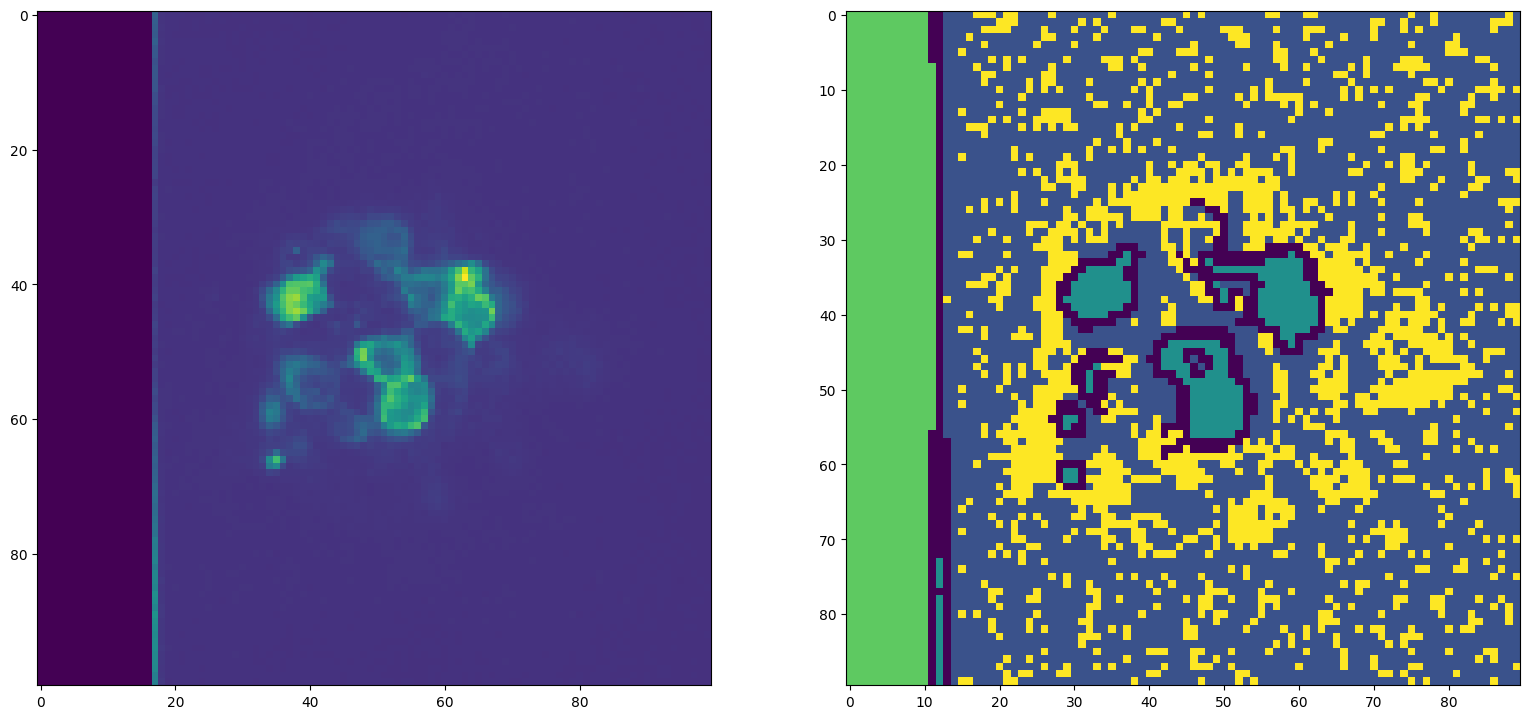

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,20))
plt.subplot(1,4,1)
plt.imshow(image)
plt.subplot(1,4,2)
plt.imshow(clustered_image)